In [1]:
import sys
import os
import datetime as dtm
from subprocess import Popen, PIPE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

## Fetch squeue data and construct a full table ##

In [2]:
with Popen(['ssh', 'bridges.psc.edu', 'squeue', '--array', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

['ACCOUNT', 'TRES_PER_NODE', 'MIN_CPUS', 'MIN_TMP_DISK', 'END_TIME', 'FEATURES', 'GROUP', 'OVER_SUBSCRIBE', 'JOBID', 'NAME', 'COMMENT', 'TIME_LIMIT', 'MIN_MEMORY', 'REQ_NODES', 'COMMAND', 'PRIORITY', 'QOS', 'REASON', '', 'ST', 'USER', 'RESERVATION', 'WCKEY', 'EXC_NODES', 'NICE', 'S:C:T', 'JOBID', 'EXEC_HOST', 'CPUS', 'NODES', 'DEPENDENCY', 'ARRAY_JOB_ID', 'GROUP', 'SOCKETS_PER_NODE', 'CORES_PER_SOCKET', 'THREADS_PER_CORE', 'ARRAY_TASK_ID', 'TIME_LEFT', 'TIME', 'NODELIST', 'CONTIGUOUS', 'PARTITION', 'PRIORITY', 'NODELIST(REASON)', 'START_TIME', 'STATE', 'UID', 'SUBMIT_TIME', 'LICENSES', 'CORE_SPEC', 'SCHEDNODES', 'WORK_DIR']


In [3]:
def parse_time(tstr):
    if '-' in tstr:
        days, tstr = tstr.split('-')
        days = int(days)
    else:
        days = 0
    words = tstr.split(':')
    tot = 0
    for word in words:
        tot += 60 * tot + int(word)
    tot += 24 * 60 * 60 * days
    return tot

# parse_time('3-00:04:05')

In [4]:
integer_fields = ['MIN_CPUS', 'MIN_TMP_DISK', 'JOBID', 'PRIORITY', 'CPUS', 'NODES', 'ARRAY_JOB_ID']
time_fields = ['TIME_LIMIT', 'TIME_LEFT', 'TIME']

# Convert strings to appropriate field types in place
for rec in recL:
    for key in integer_fields:
        try:
            rec[key] = int(rec[key])
        except TypeError:
            pass
    for key in time_fields:
        try:
            rec[key] = parse_time(rec[key])
        except ValueError:
            print('time interval conversion failed: %s = %s' % (key, rec[key]))
            print(rec)
            rec[key] = 0
    rec['TIME_SINCE_SUBMIT'] = (time_of_read - dtm.datetime.fromisoformat(rec['SUBMIT_TIME'])).total_seconds()

# print(recL[0])

In [5]:
fullDF = pd.DataFrame.from_records(recL)
print(fullDF.columns)
#fullDF

Index(['', 'ACCOUNT', 'ARRAY_JOB_ID', 'ARRAY_TASK_ID', 'COMMAND', 'COMMENT',
       'CONTIGUOUS', 'CORES_PER_SOCKET', 'CORE_SPEC', 'CPUS', 'DEPENDENCY',
       'END_TIME', 'EXC_NODES', 'EXEC_HOST', 'FEATURES', 'GROUP', 'JOBID',
       'LICENSES', 'MIN_CPUS', 'MIN_MEMORY', 'MIN_TMP_DISK', 'NAME', 'NICE',
       'NODELIST', 'NODELIST(REASON)', 'NODES', 'OVER_SUBSCRIBE', 'PARTITION',
       'PRIORITY', 'QOS', 'REASON', 'REQ_NODES', 'RESERVATION', 'S:C:T',
       'SCHEDNODES', 'SOCKETS_PER_NODE', 'ST', 'START_TIME', 'STATE',
       'SUBMIT_TIME', 'THREADS_PER_CORE', 'TIME', 'TIME_LEFT', 'TIME_LIMIT',
       'TIME_SINCE_SUBMIT', 'TRES_PER_NODE', 'UID', 'USER', 'WCKEY',
       'WORK_DIR'],
      dtype='object')


In [6]:
fullDF['JOBS'] = 1
fullDF['CPU_SEC_USED'] = fullDF['CPUS'] * fullDF['TIME']
fullDF['CPU_SEC_REMAIN'] = fullDF['CPUS'] * fullDF['TIME_LEFT']
#fullDF

## Fetch sinfo data and construct a full table ##

In [7]:
with Popen(['ssh', 'bridges.psc.edu', 'sinfo', '--format', '%all'], stdout=PIPE) as proc:
    recs = proc.stdout.readlines()

time_of_read_sinfo = dtm.datetime.now()

cols = recs[0].decode().strip().split('|')
print(cols)
recs = recs[1:]

recL = []
for rec in recs:
    recL.append({a : b for a, b in zip(cols, rec.decode().strip().split('|'))})

sinfoDF = pd.DataFrame.from_records(recL)

['AVAIL', 'ACTIVE_FEATURES', 'CPUS', 'TMP_DISK', 'FREE_MEM', 'AVAIL_FEATURES', 'GROUPS', 'OVERSUBSCRIBE', 'TIMELIMIT', 'MEMORY', 'HOSTNAMES', 'NODE_ADDR', 'PRIO_TIER', 'ROOT', 'JOB_SIZE', 'STATE', 'USER', 'VERSION', 'WEIGHT', 'S:C:T', 'NODES(A/I) ', 'MAX_CPUS_PER_NODE ', 'CPUS(A/I/O/T) ', 'NODES ', 'REASON ', 'NODES(A/I/O/T) ', 'GRES ', 'TIMESTAMP ', 'PRIO_JOB_FACTOR ', 'DEFAULTTIME ', 'PREEMPT_MODE ', 'NODELIST ', 'CPU_LOAD ', 'PARTITION ', 'PARTITION ', 'ALLOCNODES ', 'STATE ', 'USER ', 'CLUSTER ', 'SOCKETS ', 'CORES ', 'THREADS']


In [8]:
def split_counts(row):
    fields = row['CPUS(A/I/O/T) '].split('/')
    n_A, n_I, n_O, n_T = [int(fld) for fld in fields]
    return pd.Series({'n_A':n_A, 'n_I':n_I, 'n_O':n_O, 'n_T':n_T})

In [9]:
df = sinfoDF.apply(split_counts, axis=1)
sinfoDF = pd.concat([sinfoDF, df], axis=1)

## Tables of running jobs by partition and user ##

In [10]:
runDF = fullDF[fullDF.STATE == 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN']]
for partition, df in runDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN
PARTITION,USER,ACCOUNT,,,,,,
DBMI,singla,bi561ip,53,53,2,2,549993,1024425


CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
DBMI-GPU  yanwuxu bi561ip    32        32      3     3       4076712   
          singla  bi561ip    32        32      1     1        214464   
          yuke    bi561ip    16        16      1     1         99840   

                           CPU_SEC_REMAIN  
PARTITION USER    ACCOUNT                  
DBMI-GPU  yanwuxu bi561ip         1543832  
          singla  bi561ip         5406080  
          yuke    bi561ip          375456

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU       jacoba97 mr5fpnp   128         1      4     1        245248   
          bjc      ct4s8bp   112        16      4     4       1975680   
          hemma011 mc5pifp   112        56      4     2        625576   
          lqz0332  mc4s90p    56        56      2     2       4746028   
          sfan19   mc4sb2p    32        32      1     1       2264768   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU       jacoba97 mr5fpnp          340224  
          bjc      ct4s8bp        17696224  
          hemma011 mc5pifp         2493120  
          lqz0332  mc4s90p         5089924  
          sfan19   mc4sb2p          590976

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU-AI    zinanl   ir5fpvp   112       112      7     7       7888016   
          doa14    ac5pi3p    32        32      1     1          9408   
          singla   ac5616p    28        28      1     1        187740   
          juc91    ac5616p     4         4      1     1         15964   
          bpollack ac5616p     4         4      1     1         18468   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
GPU-AI    zinanl   ir5fpvp        11783888  
          doa14    ac5pi3p          464896  
          singla   ac5616p         4730236  
          juc91    ac5616p          102860  
          bpollack ac5616p          100356

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER     ACCOUNT                                              
GPU-shared koolben  mc5623p   112       112     16    16       1818684   
           ccheni   mr5fq0p    32        32      2     2       1341920   
           lqz0332  mc4s90p    28        28      1     1        456848   
           robertoc cc5phvp    16        16      1     1        204304   
           yag218   mc4s95p    16        16      1     1        675072   
           ay00luwa mc5pi5p    14        14      2     2         15435   

                             CPU_SEC_REMAIN  
PARTITION  USER     ACCOUNT                  
GPU-shared koolben  mc5623p        17853220  
           ccheni   mr5fq0p         4278624  
           lqz0332  mc4s90p         4461128  
           robertoc cc5phvp         2605968  
           yag218   mc4s95p         2135200  
           ay00luwa mc5pi5p           10171

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER    ACCOUNT                                              
GPU-small rachels eg5fp3p    32        32      1     1           512   
          qzhang8 ch5fq5p    16        16      1     1         57168   

                           CPU_SEC_REMAIN  
PARTITION USER    ACCOUNT                  
GPU-small rachels eg5fp3p          950080  
          qzhang8 ch5fq5p          418128

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
LM        yundi    mr5fqkp  1456      1456     52    52      38427928   
          vishnur  ms5pi1p   256         4      4     4      12588096   
          xcgalaxy mc48nsp   248        24     24    24       6991330   
          akhodkar at560kp   159        15     15    15       2658717   
          fdeng    bi561cp   100       100      2     2       3096880   
          daloisio as560pp    99         3      3     3      57308658   
          pipes    bi5fpfp    65         5      5     5     164566350   
          alelim   mc5fr6p    64         1      1     1         32384   
          grgmncr  ib5fpip    64         1      1     1        925376   
          bnaiden  mc5fr6p    64         1      1     1      16455872   
          karly11  oc5fp4p    42         6      6     6        182791   
          lizhen09 mc3uv6p    42         3      3     3       2847194   
          ccain002 as560pp    33         1      1     1      10688799   
          levandbj mc5fs9p    32         2      2     2        547840   
          xiej     ci4s87p    28        28      1     1       3165176   
          vkivenso eb560kp    22         1      1     1        119856   
          rachbay  bi4ifup    16        16      1     1       9852176   
          waynew   biccnro    12         2      2     2      11401302   
          fralston ec5fp6p    10         1      1     1       1723170   
          jchang0  bi5fpfp     8         1      1     1       2729912   
          mej85    mc5pijp     7         1      1     1          1596   
          jj65     cc3bdup     6         2      2     2         88353   
          bdp65    eb5phjp     3         1      1     1          3882   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
LM        yundi    mr5fqkp       217306824  
          vishnur  ms5pi1p       297797056  
          xcgalaxy mc48nsp        68535886  
          akhodkar at560kp       116831871  
          fdeng    bi561cp       118147320  
          daloisio as560pp        62723100  
          pipes    bi5fpfp        71490380  
          alelim   mc5fr6p        77563904  
          grgmncr  ib5fpip        76670912  
          bnaiden  mc5fr6p        61140416  
          karly11  oc5fp4p        25338173  
          lizhen09 mc3uv6p         8158570  
          ccain002 as560pp        29321787  
          levandbj mc5fs9p          402752  
          xiej     ci4s87p         6591200  
          vkivenso eb560kp         1352296  
          rachbay  bi4ifup         7450064  
          waynew   biccnro         3148002  
          fralston ec5fp6p           33250  
          jchang0  bi5fpfp         6969624  
          mej85    mc5pijp          323771  
          jj65     cc3bdup           89883  
          bdp65    eb5phjp          263844

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM        uscms    ph561hp  2772        99     99    99     284851028   
          jhealy   ph4s8hp  1456       140     52    10      97392120   
          esh27    ph5616p  1344       288     48    12      62745536   
          khelashv mc4ignp  1344       112     48     4      83795712   
          kalyani  mc5fplp  1120       112     40     4      33101824   
          hjoshi   mt7o2cp  1120         2     40     2      39617200   
          hcasquer eg560mp  1092        26     39     1       4246788   
          rmartin3 mr5fqlp   896        32     32    32     354325104   
          emensah  ch4ifvp   672         3     24     3       6037920   
          chernogl ph4s83p   560       112     20     4      50303540   
          ldyke    ph5phjp   560        28     20     1      11217920   
          rokoni   ct3bdrp   448       112     16     4       4501280   
          vijayuic ph4ifjp   448        84     16     3      12026896   
          ajer95   mr4ifsp   448        24     16     1       4035584   
          bs674    mc5pilp   392        14     14    14       1294832   
          prodrigu be5fpfp   336         1     12     1       3398640   
          sukruth3 ct3uuhp   308        28     11     1       3113264   
          buchum   mr5pi4p   252        84      9     3       2280544   
          noamb    cc8r6kp   224         8      8     8      50081696   
          rgh2     ms5fp7p   224         4      8     4      13927200   
          gchong   ch4ifvp   224         1      8     1      15376256   
          hhy      mr5629p   196         7      7     7      16461340   
          jliuf    ch4s8jp   140       140      5     5       9550352   
          ffoucart ph4s83p   140        28      5     1      13695500   
          jchaklad mc5fsap   140        14      5     1       9284800   
          llmock   ss5fpep   112       112      4     4       1205120   
          rt887917 mr5phop   112        56      4     2       9510480   
          dilipblr ct5fplp   112         1      4     1       2536688   
          koolben  mc5623p   112        28      4     1       2536800   
          tabedzki mr5fpop    56        56      2     2        207648   
          jsager   ch4ifup    56        56      2     2        216216   
          telder   mc3l8up    56        56      2     2        677600   
          ajreddy  ib5fphp    56         2      2     2       3135216   
          mhennefa ch4s8jp    56        32      2     2       1148280   
          mbruchon dd5fp4p    56        32      2     2       4242000   
          sfarhat  oc4ifip    56        28      2     1        216496   
          mscheel  ph4s83p    56        28      2     1       1267168   
          ksubedi  mr5phop    56        28      2     1        566384   
          naum52   ph5fp6p    56        28      2     1       3689448   
          gcommuni ch87lmp    28         1      1     1       4896360   
          lafredin ch5fq0p    28        28      1     1        287196   
          lkuehn   se5610p    28         1      1     1       1979964   
          hkimaf   ch5fqap    28        24      1     1       2257780   
          smalviya ct5phjp    28        28      1     1        108892   
          maoye    se5phip    28        28      1     1        283360   
          huanw    mr5fqhp    28        28      1     1       3357228   
          junyan26 ci48n2p    28         1      1     1        375088   
          yaol     dd5fp7p    28         8      1     1       4417868   
          ccompute ca560lp    28        28      1     1        357588   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM        uscms    ph561hp       202028624  
          jhealy   ph4s8hp       158342632  
          esh27    ph5616p       173317312  
          khelashv mc4ignp       152267136  
          kalyani  mc5fplp        

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared joyjit   mr4s81p   179       179    179   179       9805240   
          krieger  db3uump    31        31     31    31        192019   
          hhy      mr5629p    28         1      1     1       4478432   
          ronfisch mr5fp3p    18        18      9     9       1006524   
          jcooke   ct560ip    12        12      1     1        848712   
          rsingh3  ch4ifvp    11        11     11    11        345465   
          afshin67 ir5fppp     4         4      4     4         13150   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM-shared joyjit   mr4s81p         6169079  
          krieger  db3uump          267463  
          hhy      mr5629p          439544  
          ronfisch mr5fp3p         2155032  
          jcooke   ct560ip         1258992  
          rsingh3  ch4ifvp         1586597  
          afshin67 ir5fppp          689418

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-small  mka721   mr4s8rp    56         1      2     1        312368   
          tzhuang  as5fpep    20         1      1     1         15120   
          ntpierce mc5phkp    14        14      1     1          1162   
          vijayuic ph4ifjp     1         1      1     1          2870   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
RM-small  mka721   mr4s8rp         1351168  
          tzhuang  as5fpep          430160  
          ntpierce mc5phkp           50064  
          vijayuic ph4ifjp           26836

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
XLM       mbcouger mc3v0jp   255         1      1     1      35664555   
          alelim   mc5fr6p   255         1      1     1     218247360   

                            CPU_SEC_REMAIN  
PARTITION USER     ACCOUNT                  
XLM       mbcouger mc3v0jp       100098720  
          alelim   mc5fr6p        90925350

## Tables of queued jobs by partition and user ##

In [11]:
waitDF = fullDF[fullDF.STATE != 'RUNNING'][['PARTITION', 'USER', 'ACCOUNT', 'CPUS', 'MIN_CPUS', 'NODES',
                                           'JOBS', 'CPU_SEC_USED', 'CPU_SEC_REMAIN', 'TIME_SINCE_SUBMIT']]
for partition, df in waitDF.groupby(['PARTITION', 'USER', 'ACCOUNT']).sum().groupby('PARTITION'):
    display(df.sort_values(by=['CPUS', 'JOBS', 'CPU_SEC_REMAIN'], ascending=False))

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
GPU       fnaugh   mc4sb2p   672       672     21    21             0   
          sfan19   mc4sb2p   192       192      6     6             0   
          heaths   ph4s81p   160       160      5     5             0   
          vbrik    ph4s81p   160       160      5     5             0   
          potoyan  mc5fqtp    64        64      2     2             0   
          hemma011 mc5pifp    56        28      2     1             0   
          jazellim mc5fqtp    32        32      1     1             0   
          as170    at560kp    32        32      1     1             0   
          lqz0332  mc4s90p    28        28      1     1             0   
          nwauer   mc4s85p    12        12      3     3             0   
          kavvyom  ca4s8fp     4         2      4     2             0   
          rachels  eg5fp3p     1         1      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
GPU       fnaugh   mc4sb2p        58060800       1.047956e+07  
          sfan19   mc4sb2p        16588800       5.686191e+06  
          heaths   ph4s81p        27648000       5.311323e+05  
          vbrik    ph4s81p        27648000       5.311323e+05  
          potoyan  mc5fqtp        11059200       2.887679e+05  
          hemma011 mc5pifp         2083760       6.758468e+03  
          jazellim mc5fqtp         5529600       1.013847e+04  
          as170    at560kp         2764800       6.218947e+04  
          lqz0332  mc4s90p         4838400       1.946843e+01  
          nwauer   mc4s85p         2073600       2.786084e+05  
          kavvyom  ca4s8fp          691200       2.527279e+05  
          rachels  eg5fp3p           29768       1.454684e+02

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION  USER     ACCOUNT                                              
GPU-shared yag218   mc4s95p   352       352     22    22             0   
           vbrik    ph4s81p   160       160      5     5             0   
           cbores   mtsg3hp   144       144      9     9             0   
           gumbart  mc4s9op   128       128      4     4             0   
           jjal226  mc5fplp    96        96      6     6             0   
           heaths   ph4s81p    64        64      4     4             0   
           gaofy    mr562bp    48        48      3     3             0   
           koolben  mc5623p    35        35      5     5             0   
           lqz0332  mc4s90p    28        28      1     1             0   
           macintyr syr54jp    28        28      1     1             0   
           robertoc cc5phvp    16        16      1     1             0   
           ay00luwa mc5pi5p     7         7      1     1             0   

                             CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION  USER     ACCOUNT                                     
GPU-shared yag218   mc4s95p        60825600       2.690317e+06  
           vbrik    ph4s81p        27648000       5.311343e+05  
           cbores   mtsg3hp        24883200       1.280456e+06  
           gumbart  mc4s9op        22118400       1.648620e+06  
           jjal226  mc5fplp        16588800       1.052158e+05  
           heaths   ph4s81p        11059200       3.401869e+05  
           gaofy    mr562bp         8294400       1.634314e+05  
           koolben  mc5623p         6048000       7.673834e+04  
           lqz0332  mc4s90p         4838400       1.746843e+01  
           macintyr syr54jp           25620       1.324684e+02  
           robertoc cc5phvp         2764800       1.307847e+04  
           ay00luwa mc5pi5p         1209600       6.246843e+01

,,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT
PARTITION,USER,ACCOUNT,,,,,,,
LM,yundi,mr5fqkp,112,112,4,4,0,19353600,15.873724


CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                               
RM        severin  mc48o5p  39732      1419   1419  1419             0   
          khelashv mc4ignp  22848      1904    816    68             0   
          maciej   mc5610p  15288       364    546    13             0   
          kalyani  mc5fplp  15232      1092    544    39             0   
          hcasquer eg560mp  14000       364    546    14             0   
          bdong    as4ifmp  10304       140    368     5             0   
          gnawrock mc5610p   9408       224    336     8             0   
          hjoshi   mt7o2cp   7140        12    255    12             0   
          bs674    mc5pilp   4982      4982   4982  4982             0   
          snikolov mr5fpfp   4200        28    150     1             0   
          chant    as4ifmp   2000        20    125     5             0   
          elambros ch48n2p   1792        56     64     2             0   
          huz071   mr561jp    756       252     27     9             0   
          telder   mc3l8up    560       560     20    20             0   
          cchoban  as4ifmp    560        56     20     2             0   
          lindsb   mr5fpop    504       504     18    18             0   
          rmartin3 mr5fqlp    420        15     15    15             0   
          uthpala  ph4ifjp     96        43     96    43             0   
          tabedzki mr5fpop     84        84      3     3             0   
          mhennefa ch4s8jp     58        30      3     2             0   
          ningwang mr5phkp     56        28      2     1             0   
          lwinch   ca5phmp     28        28      1     1             0   
          rprad009 mr4s90p     28        28      1     1             0   
          xdtas    cc3l68p     28        28      1     1             0   
          glumaj   syr54jp      4         2      4     2             0   
          uscms    ph561hp      1         1      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
RM        severin  mc48o5p      6865689600       1.819362e+09  
          khelashv mc4ignp      3948134400       7.017163e+07  
          maciej   mc5610p      2641766400       9.005637e+07  
          kalyani  mc5fplp       793495808       3.369146e+07  
          hcasquer eg560mp      2419200000       1.482259e+07  
          bdong    as4ifmp      1780531200       4.765306e+06  
          gnawrock mc5610p      1625702400       5.541640e+07  
          hjoshi   mt7o2cp      1090266240       1.769567e+06  
          bs674    mc5pilp       379877500       2.681058e+07  
          snikolov mr5fpfp         2562000       1.781284e+06  
          chant    as4ifmp       345600000       3.289712e+06  
          elambros ch48n2p       133360640       4.133645e+06  
          huz071   mr561jp       130636800       7.215821e+07  
          telder   mc3l8up        96768000       1.299437e+04  
          cchoban  as4ifmp        96768000       2.596937e+03  
          lindsb   mr5fpop        87091200       1.408443e+04  
          rmartin3 mr5fqlp        72576000       5.906003e+04  
          uthpala  ph4ifjp        16588800       1.932214e+04  
          tabedzki mr5fpop        14515200       1.633441e+04  
          mhennefa ch4s8jp        10022400       1.167094e+04  
          ningwang mr5phkp         9676800       1.674684e+02  
          lwinch   ca5phmp          208376       8.574455e+05  
          rprad009 mr4s90p           17080       1.503468e+03  
          xdtas    cc3l68p            5124       9.324684e+02  
          glumaj   syr54jp          691200       3.421937e+03  
          uscms    ph561hp          172800       4.884468e+03

CPUS  MIN_CPUS  NODES  JOBS  CPU_SEC_USED  \
PARTITION USER     ACCOUNT                                              
RM-shared nsnichol mr5pi0p   622       622    622   622             0   
          hhy      mr5629p   420        15     15    15             0   
          jcooke   ct560ip   312       312     26    26             0   
          joyjit   mr4s81p   221       221    221   221             0   
          rsingh3  ch4ifvp   142       142    142   142             0   
          afshin67 ir5fppp   108       108    108   108             0   
          bwang9   mr5610p    64        64      4     4             0   
          shawpa   mc5fpbp    29        29     12    12             0   
          tfobe    ct4s8bp    10        10      1     1             0   
          krieger  db3uump     4         4      4     4             0   
          ccompute ca560lp     2         2      1     1             0   
          sukruth3 ct3uuhp     1         1      1     1             0   
          schoover ct5phjp     1         1      1     1             0   
          dweindl  ac560tp     1         1      1     1             0   

                            CPU_SEC_REMAIN  TIME_SINCE_SUBMIT  
PARTITION USER     ACCOUNT                                     
RM-shared nsnichol mr5pi0p        34716930       1.032672e+08  
          hhy      mr5629p        72576000       2.066239e+06  
          jcooke   ct560ip        53913600       4.509396e+06  
          joyjit   mr4s81p        19094400       1.426786e+07  
          rsingh3  ch4ifvp        24537600       5.566769e+06  
          afshin67 ir5fppp        18662400       2.256215e+06  
          bwang9   mr5610p        11059200       2.486059e+05  
          shawpa   mc5fpbp          528382       2.766156e+05  
          tfobe    ct4s8bp         1347730       4.814447e+04  
          krieger  db3uump           59536       5.323874e+03  
          ccompute ca560lp            7442       5.614684e+02  
          sukruth3 ct3uuhp          172800       1.864147e+04  
          schoover ct5phjp            3721       1.559963e+06  
          dweindl  ac560tp              61       4.274847e+04

In [12]:
fullDF.STATE.unique()

array(['CONFIGURING', 'PENDING', 'RUNNING'], dtype=object)

## Table of average wait time by user ##

In [13]:
df = waitDF[waitDF.PARTITION == 'RM-shared'].groupby(['USER', 'ACCOUNT']).sum()
df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)

,,CPUS,MIN_CPUS,NODES,JOBS,CPU_SEC_USED,CPU_SEC_REMAIN,TIME_SINCE_SUBMIT,MEAN_TIME_SINCE_SUBMIT
USER,ACCOUNT,,,,,,,,
schoover,ct5phjp,1,1,1,1,0,3721,1.559963e+06,1.559963e+06
jcooke,ct560ip,312,312,26,26,0,53913600,4.509396e+06,1.734383e+05
nsnichol,mr5pi0p,622,622,622,622,0,34716930,1.032672e+08,1.660245e+05
hhy,mr5629p,420,15,15,15,0,72576000,2.066239e+06,1.377493e+05
joyjit,mr4s81p,221,221,221,221,0,19094400,1.426786e+07,6.456047e+04
bwang9,mr5610p,64,64,4,4,0,11059200,2.486059e+05,6.215147e+04
tfobe,ct4s8bp,10,10,1,1,0,1347730,4.814447e+04,4.814447e+04
dweindl,ac560tp,1,1,1,1,0,61,4.274847e+04,4.274847e+04
rsingh3,ch4ifvp,142,142,142,142,0,24537600,5.566769e+06,3.920260e+04


## Table of CPU allocations by partition ##

In [14]:
partitionCPUDF = sinfoDF[['PARTITION ', 'n_A', 'n_I', 'n_O', 'n_T']].groupby(['PARTITION ']).sum()
partitionCPUDF

,n_A,n_I,n_O,n_T
PARTITION,,,,
DBMI,53,203,0,256
DBMI-GPU,80,16,0,96
GPU,658,686,0,1344
GPU-AI,180,276,0,456
GPU-shared,658,686,0,1344
GPU-small,48,80,0,128
LM,3458,1054,0,4512
RM,18203,2489,0,20692
RM-shared,2579,1285,0,3864


In [15]:
def  queue_plot(axes, runDF, waitDF, partition):
    blockL = []
    txtL = []
    baseX = 0.0
    baseY = 0.0
    maxLWd = 0.0
    maxTotHt = 0.0
    df = waitDF[waitDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_TIME_SINCE_SUBMIT'] = df['TIME_SINCE_SUBMIT']/df['JOBS']
    df.sort_values(['MEAN_TIME_SINCE_SUBMIT'],ascending=False)
    for idx, row in df.reset_index().sort_values(['MEAN_TIME_SINCE_SUBMIT'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['CPU_SEC_REMAIN'])/(3600. * row['CPUS'])
        rect = Rectangle((baseX, baseY), wd, ht, ec='black')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s) %.2f hours' % (row['USER'], row['ACCOUNT'],
                                                   row['MEAN_TIME_SINCE_SUBMIT']/3600.0),
                              (baseX + 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxLWd = max(maxLWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    baseX = 0.0
    baseY = 0.0
    maxRWd = 0.0
    df = runDF[runDF.PARTITION == partition].groupby(['USER', 'ACCOUNT']).sum()
    df['MEAN_HOURS_REMAIN'] = df['CPU_SEC_REMAIN']/(3600. * df['CPUS'])
    df.sort_values(['MEAN_HOURS_REMAIN'],ascending=False)
    for idx, row in df.reset_index().sort_values(['CPUS'], ascending=False).iterrows():
        ht = row['CPUS']
        wd = float(row['MEAN_HOURS_REMAIN'])
        rect = Rectangle((baseX - wd, baseY), wd, ht, ec='black', fc='red')
        blockL.append(axes.add_artist(rect))
        ltxt = plt.Annotation('%s (%s)' % (row['USER'], row['ACCOUNT']),
                              (baseX - 0.5*wd, baseY + 0.5*ht),
                              va='center', ha='center'
                             )
        txtL.append(axes.add_artist(ltxt))
        baseY += ht
        maxRWd = max(maxRWd, wd)
    maxTotHt = max(maxTotHt, baseY)
    axes.set_xlim(-maxRWd, maxLWd)
    axes.set_ylim(0.0, maxTotHt)
    axes.set_xlabel('Hours per CPU')
    axes.set_title('%s\n<- Running | Waiting ->' % partition)
    return maxTotHt

#fix, axes = plt.subplots(1)
#queue_plot(axes, runDF, waitDF, 'GPU-shared')
#plt.show()

    

In [16]:
def cpu_plot(axes, partitionCPUDF, partition):
    axes0.set_xlim(0.0, 1.0)
    baseY = 0.0
    df = partitionCPUDF.reset_index()
    for idx, row in df.iterrows():
        this_pt = row['PARTITION '].strip()
        if this_pt == partition:
            ht = row['n_A']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan')
            axes.add_artist(rect)
            ltxt = plt.Annotation('alloc', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_I']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='/')
            axes.add_artist(rect)
            ltxt = plt.Annotation('idle', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    
            ht = row['n_O']
            rect = Rectangle((0.0, baseY), 1.0, ht, ec='black', fc='cyan', hatch='+')
            axes.add_artist(rect)
            ltxt = plt.Annotation('other', (0.5, baseY + 0.5*ht), va='center', ha='center')
            axes.add_artist(ltxt)
            baseY += ht
    return baseY
    


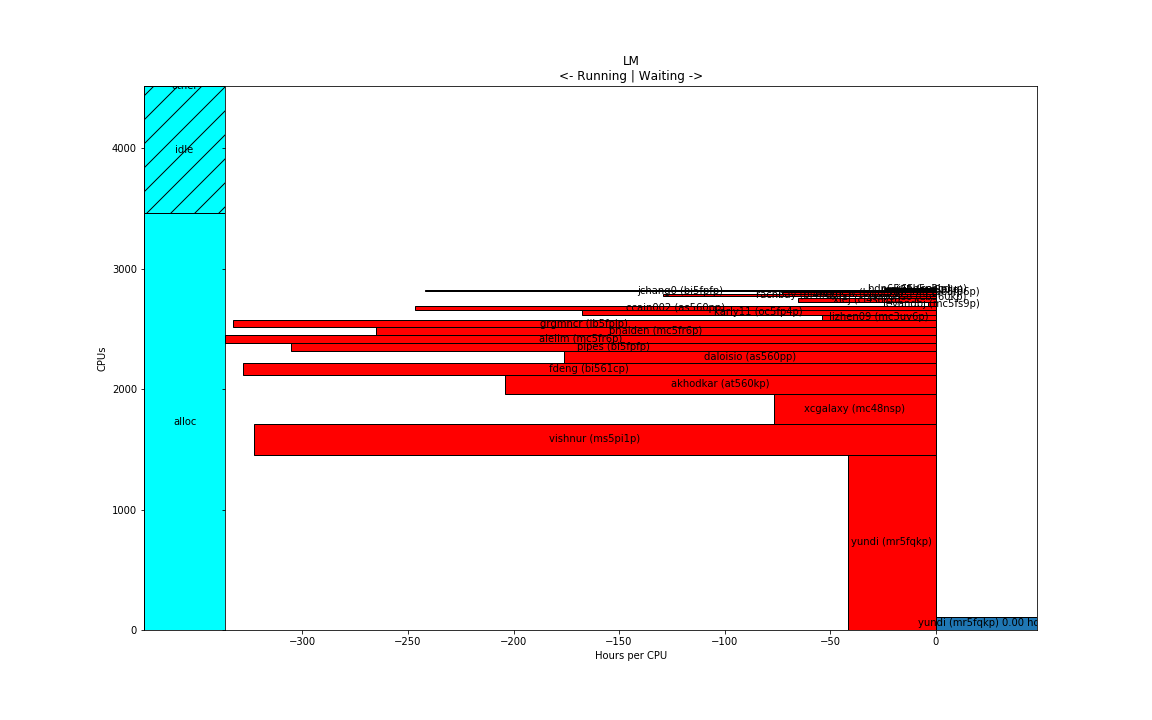

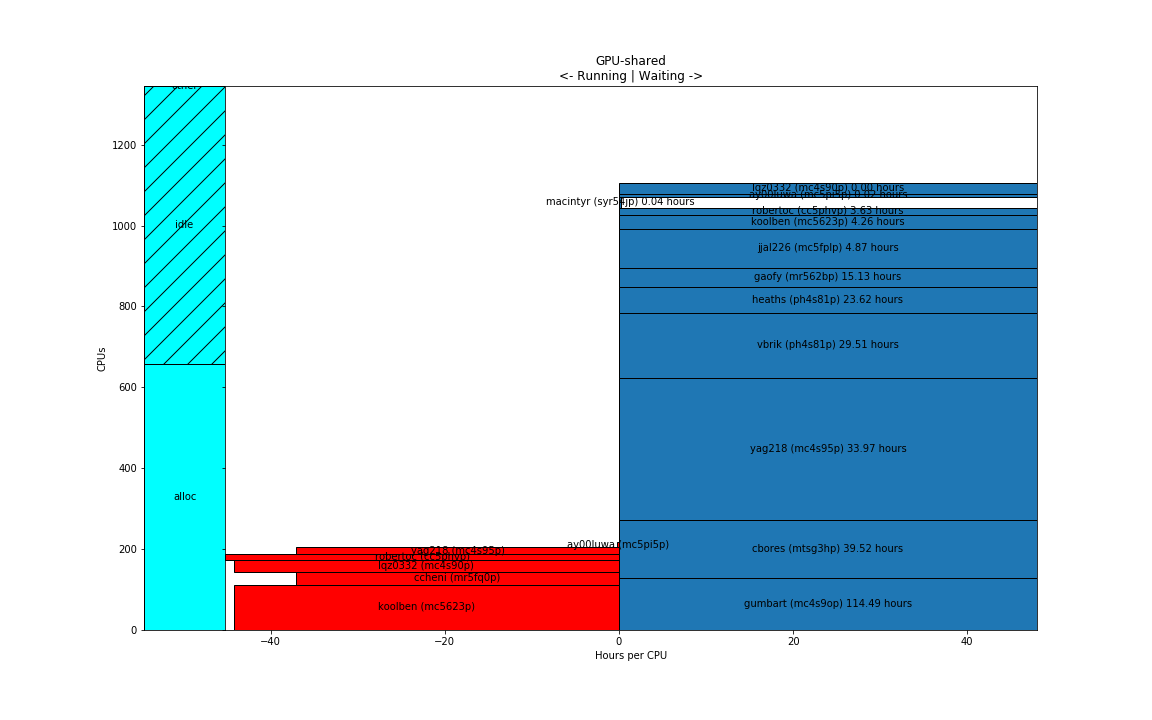

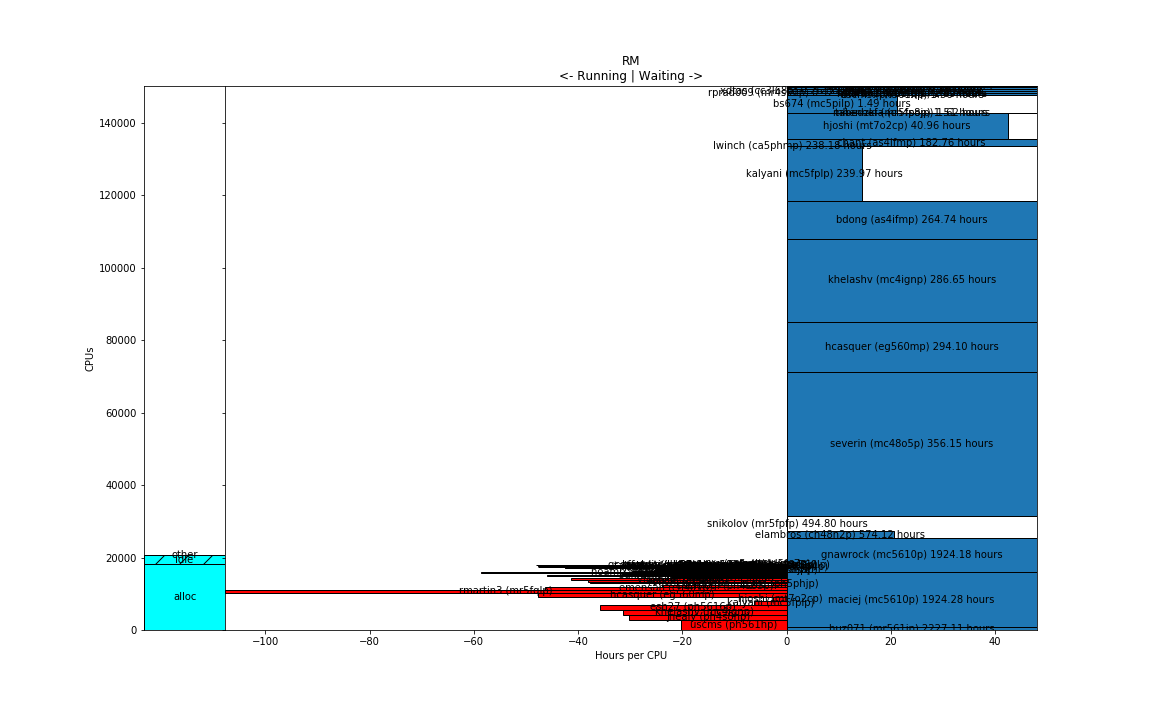

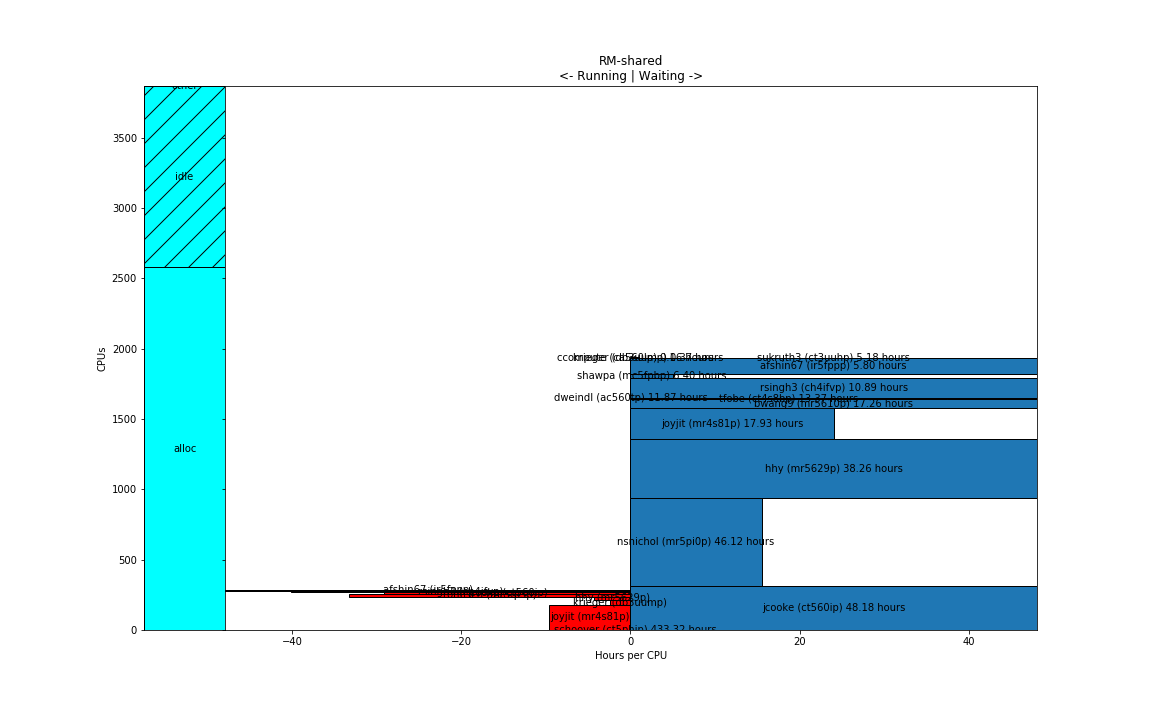

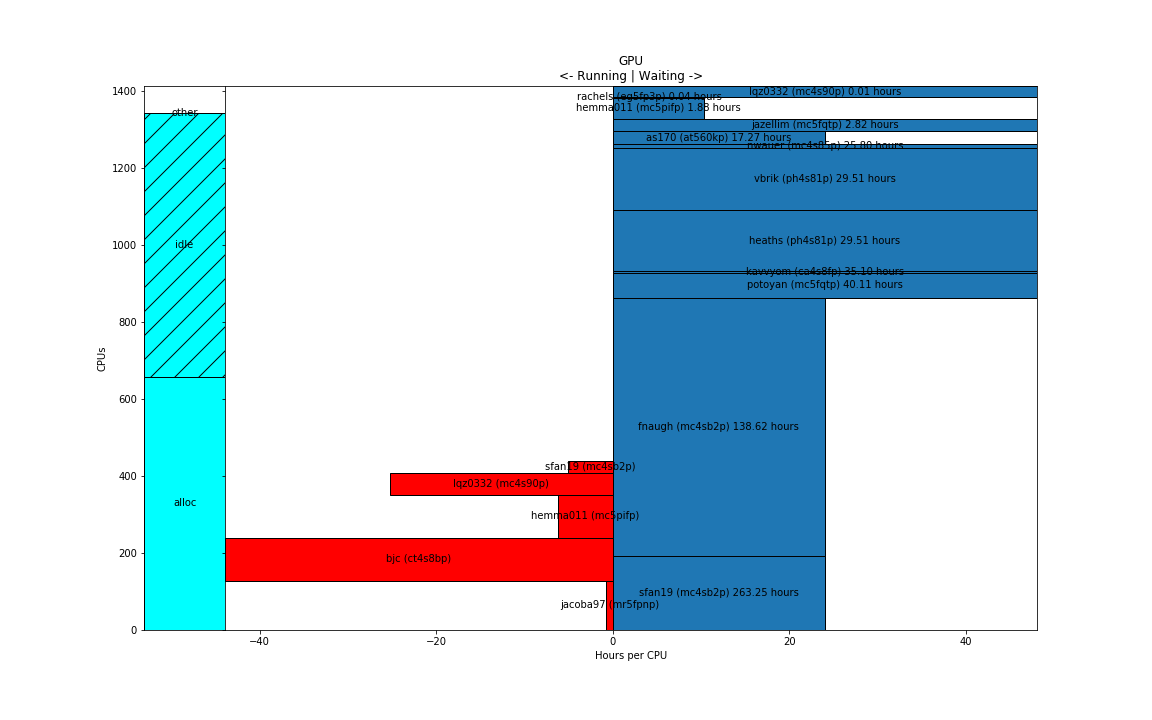

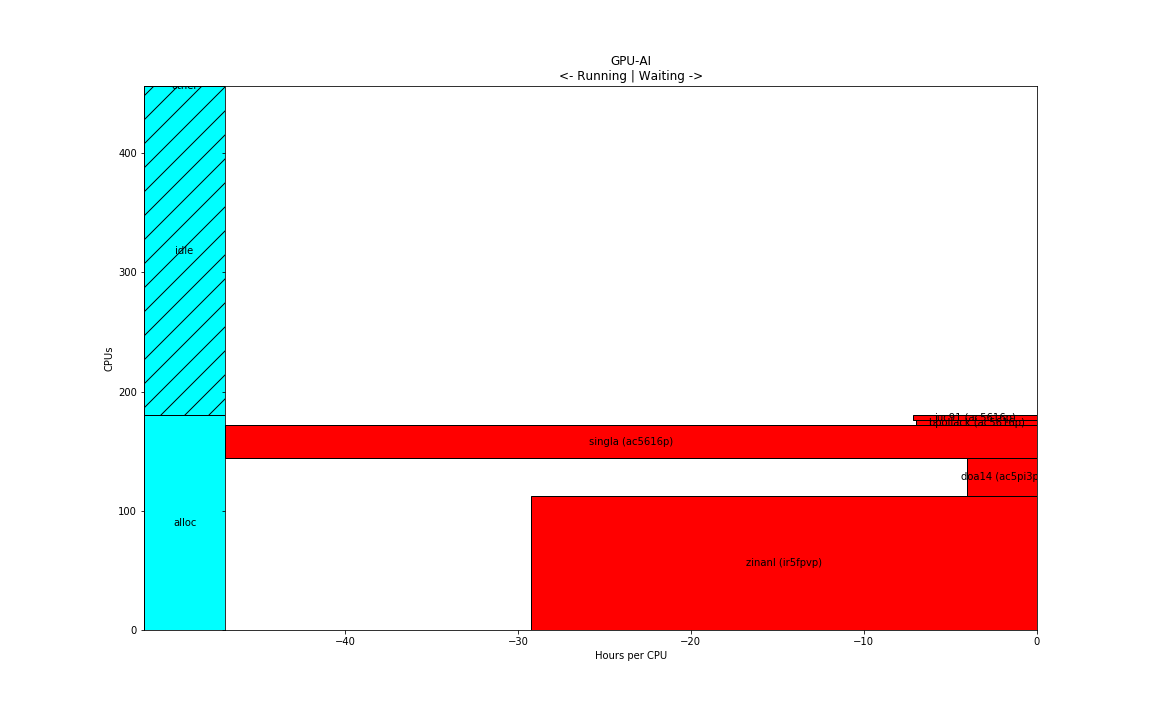

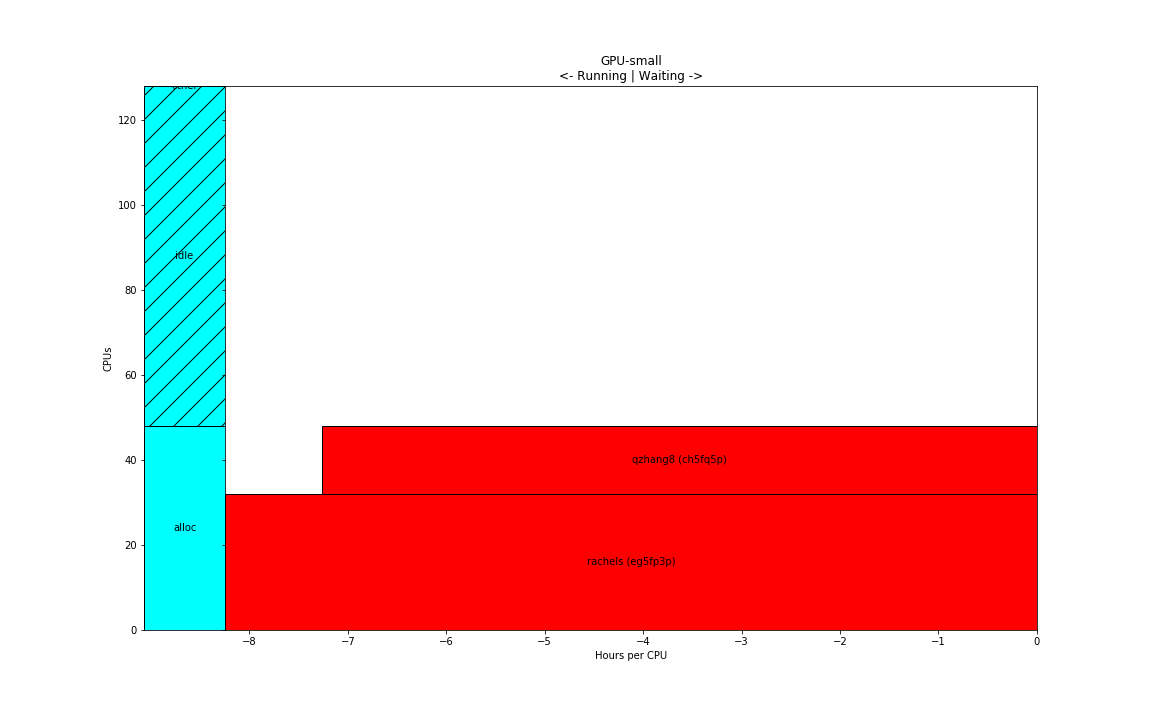

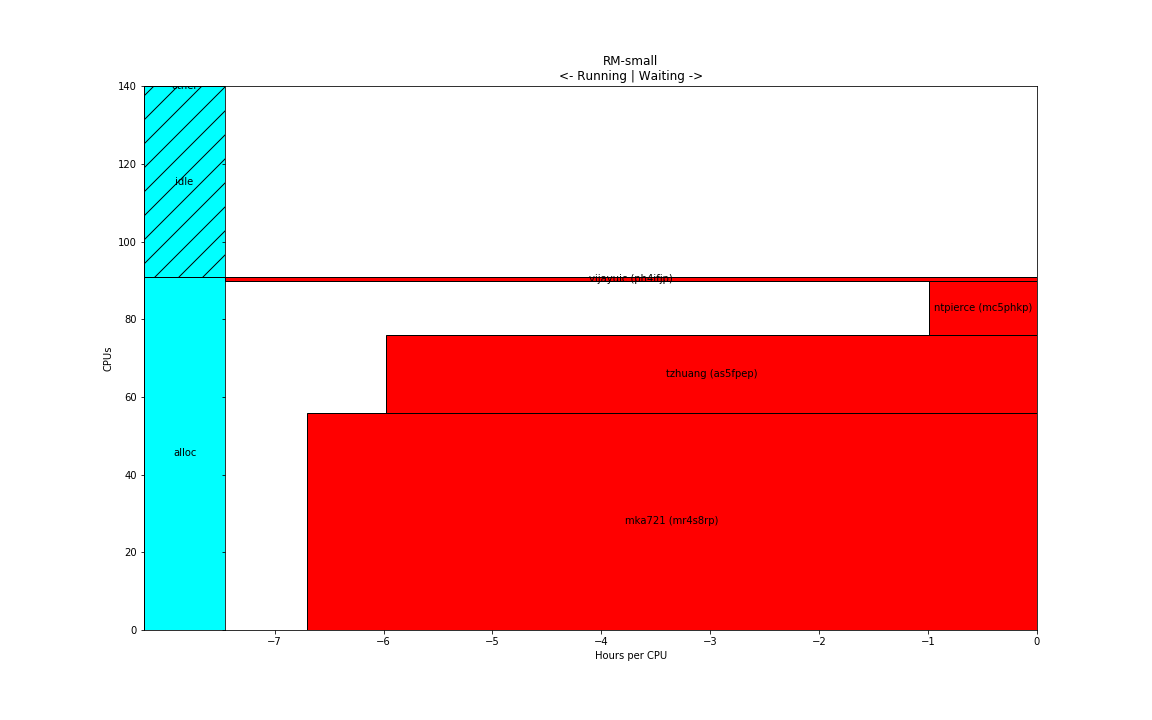

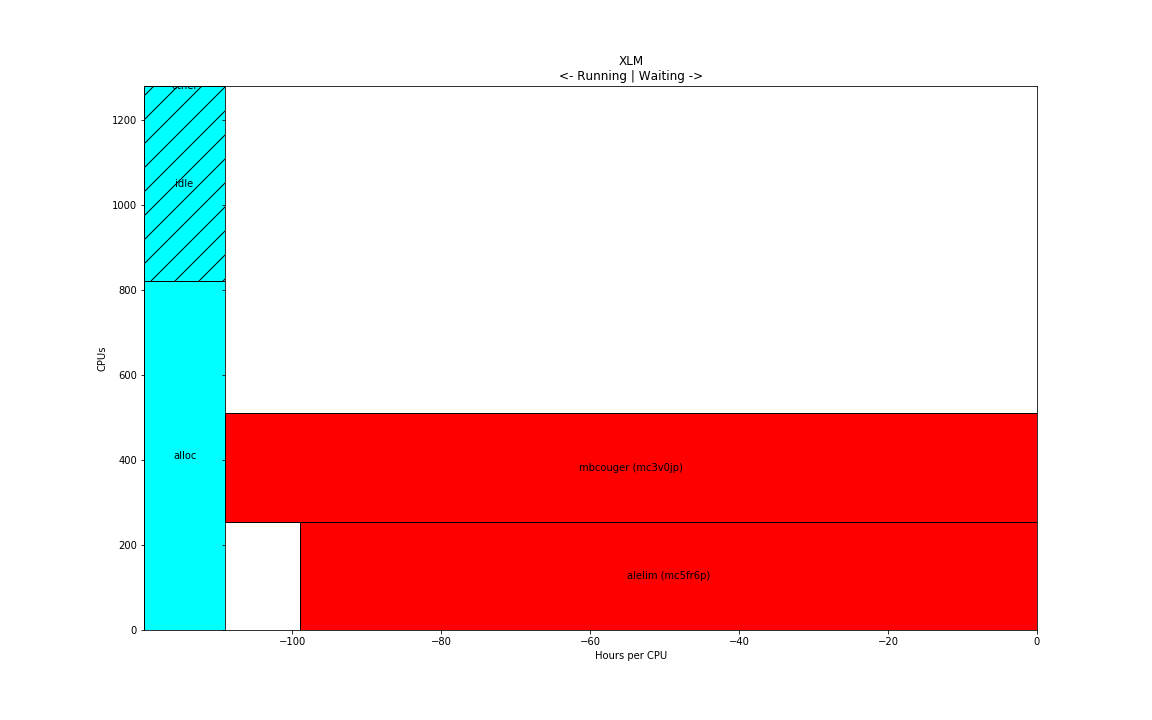

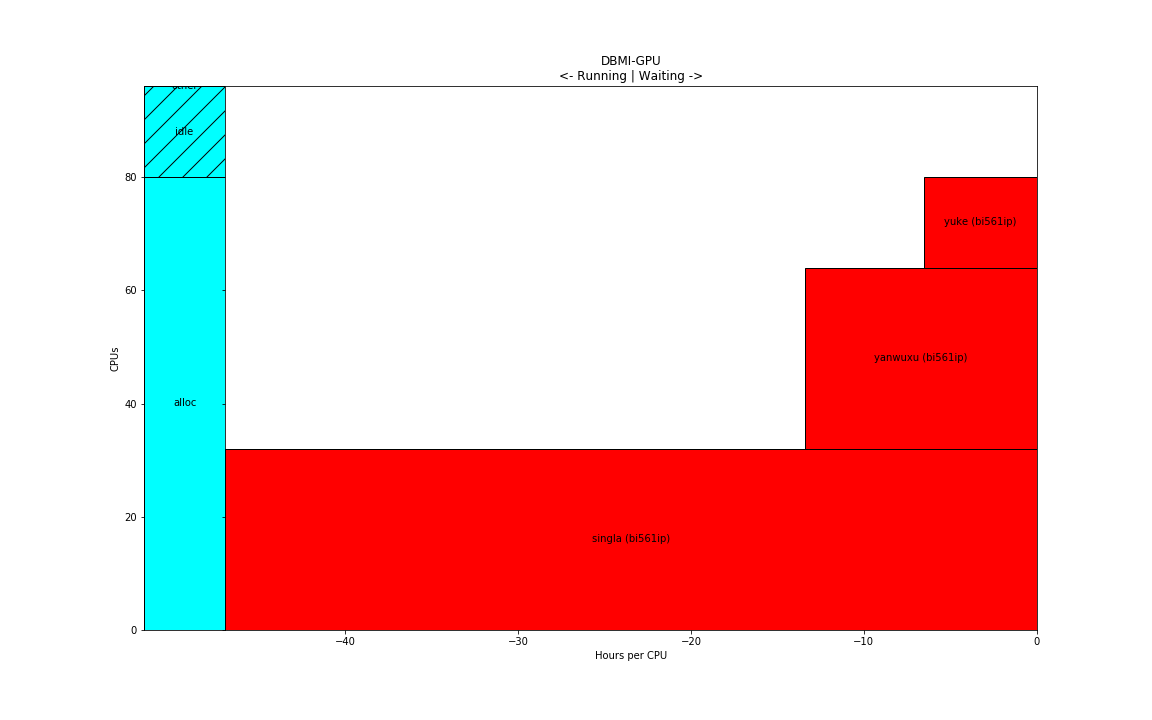

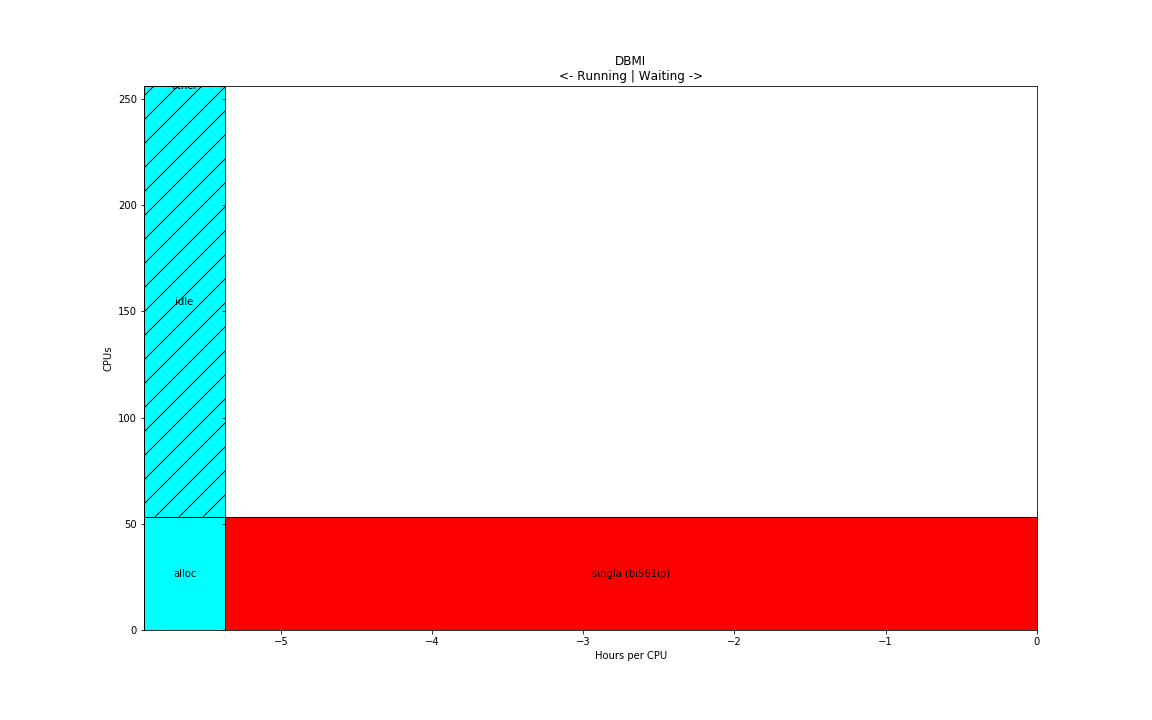

In [17]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline
#%matplotlib qt
plt.rcParams["figure.figsize"] = [16, 10]

for partition in fullDF.PARTITION.unique():
    fig = plt.figure()
    gs = GridSpec(1, 2, width_ratios=[1, 10])
    gs.update(wspace=0.0)
    axes0 = fig.add_subplot(gs[0])
    axes1 = fig.add_subplot(gs[1], sharey=axes0)
    plt.setp(axes1.get_yticklabels(), visible=False)
    axes0.set_ylabel('CPUs')
    plt.setp(axes0.get_xticklabels(), visible=False)
    axes0.get_xaxis().set_ticks([])
    ht1 = queue_plot(axes1, runDF, waitDF, partition)
    ht2 = cpu_plot(axes0, partitionCPUDF, partition)
    axes1.set_ylim(0.0, max(ht1, ht2))
    plt.show()